In [1]:
#data processing
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import dateutil.parser

#import xarray as xr
import os
import time

#data visualization
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import ticker
%matplotlib inline

#used for map projections
import cartopy.crs as ccrs
import cartopy.feature as cft
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# #widgets for user interaction
# import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')
from dateutil import parser

In [2]:
##### import local functions
# for data processing
from utilities_NSF_EC2022 import create_list_of_days,get_data_from_url, \
                                    check_list_of_list,check_list, check_list_of_dict, \
                                    get_info_from_df,get_data_for_timeRange, \
                                    check_error_message,polygon_lon_lat #,get_metadata_for_var
# for data visualization
from utilities_NSF_EC2022 import set_up_map,select_color_byList,plot_locations_withColor,set_ax_label, \
                                 set_map_and_plot_locations_withColor

In [3]:
# set parameters that will be used later for API queries

# prefix to use with all API queries
url_prefix = 'https://argovis-api-atoc-argovis-dev.apps.containers02.colorado.edu'
myAPIkey   = '8a9a6fb0a7c59b1202ffee94a719b27a173774e5'

# shape defining the region of interest (copy and paste from the browser, i.e. current "shape" parameter in the url)
# i.e. 
# 1. visit argovis.colorado.edu
# 2. draw a shape
# 3. click on the purple shaded area of the region of interest (not on a dot)
# 4. from the pop up window, go "to Selection page"
# 5. from the url of the selection shape, copy the shape, i.e. [copy_all_this_inside_outer_brackets] after 'shape='
# Example url once the shape has been drawn in step 2. above (if you visit the url, you can follow the remaining steps):
#
# https://argovis.colorado.edu/ng/home?mapProj=WM&presRange=%5B0,2000%5D&selectionStartDate=2022-03-09T23:40:31Z&selectionEndDate=2022-03-23T23:40:31Z&threeDayEndDate=2022-03-21T23:40:31&shapes=%5B%5B%5B22.389257,68.663028%5D,%5B17.320499,59.970225%5D,%5B11.897995,51.759644%5D,%5B-2.067321,51.759644%5D,%5B-6.331603,45.853643%5D,%5B-14.929825,51.9633%5D,%5B-37.056256,51.9633%5D,%5B-36.730509,62.960682%5D,%5B12.892522,74.365374%5D,%5B22.389257,68.663028%5D%5D%5D&includeRealtime=true&onlyBGC=false&onlyDeep=false&threeDayToggle=false
# 
polygon = '[[68.663028,22.389257],[59.970225,17.320499],[51.759644,11.897995],[51.759644,-2.067321],[45.853643,-6.331603],[51.9633,-14.929825],[51.9633,-37.056256],[62.960682,-36.730509],[74.365374,12.892522],[68.663028,22.389257]]'
startDate = '2018-04-27T00:00:00Z'
endDate   = '2018-06-05T00:00:00Z'
#
# ###### for Giovanni
# polygon = '[[-67.802406,20.086981],[-59.353564,20.289486],[-50.904722,20.086981],[-47.200085,-0.657769],[-53.953289,2.670715],[-60.742943,5.961994],[-67.613394,9.169258],[-67.802406,20.086981]]'
# startDate = '2007-01-01T00:00:00Z'
# endDate   = '2018-01-01T00:00:00Z'
# ######
# lon_min = -50
# lon_max = 16
# lat_min = -31
# lat_max = -25
# polygon = '[['+str(lon_min)+','+str(lat_max)+'],['+str(lon_min)+','+str(lat_min)+'],['+ \
#            str(lon_max)+','+str(lat_min)+'],['+str(lon_max)+','+str(lat_max)+'],['+str(lon_min)+','+str(lat_max)+']]'
# startDate = '2011-09-25T00:00:00Z'
# endDate   = '2011-11-01T12:00:00Z'
polygon_lon_lat_dict = polygon_lon_lat(polygon_str=polygon)

In [4]:
# other params
info_to_store = ['lon','lat','date','cols_bySource','ids','woce_line']
# plot params
dx  = 10;dy  = 10;central_long = -30

Number of items: 616
https://argovis-api-atoc-argovis-dev.apps.containers02.colorado.edu/profiles?&startDate=2018-04-27T00:00:00Z&endDate=2018-06-05T23:59:59Z&polygon=[[68.663028,22.389257],[59.970225,17.320499],[51.759644,11.897995],[51.759644,-2.067321],[45.853643,-6.331603],[51.9633,-14.929825],[51.9633,-37.056256],[62.960682,-36.730509],[74.365374,12.892522],[68.663028,22.389257]]&data=temp,metadata-only&source=argo_core
Number of items: 64
https://argovis-api-atoc-argovis-dev.apps.containers02.colorado.edu/profiles?&startDate=2018-04-27T00:00:00Z&endDate=2018-06-05T23:59:59Z&polygon=[[68.663028,22.389257],[59.970225,17.320499],[51.759644,11.897995],[51.759644,-2.067321],[45.853643,-6.331603],[51.9633,-14.929825],[51.9633,-37.056256],[62.960682,-36.730509],[74.365374,12.892522],[68.663028,22.389257]]&data=temp,metadata-only&source=argo_bgc
Number of items: 124
https://argovis-api-atoc-argovis-dev.apps.containers02.colorado.edu/profiles?&startDate=2018-04-27T00:00:00Z&endDate=2018-0

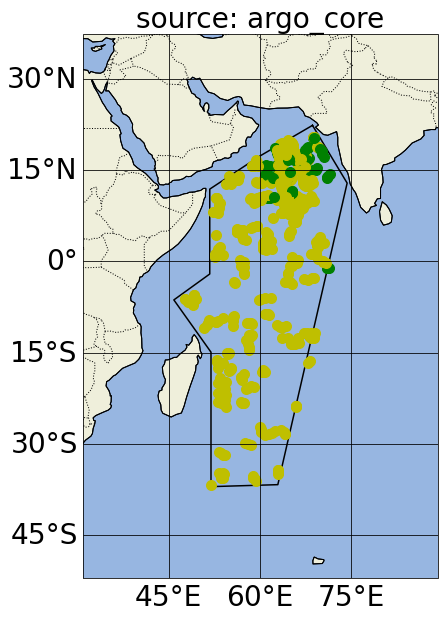

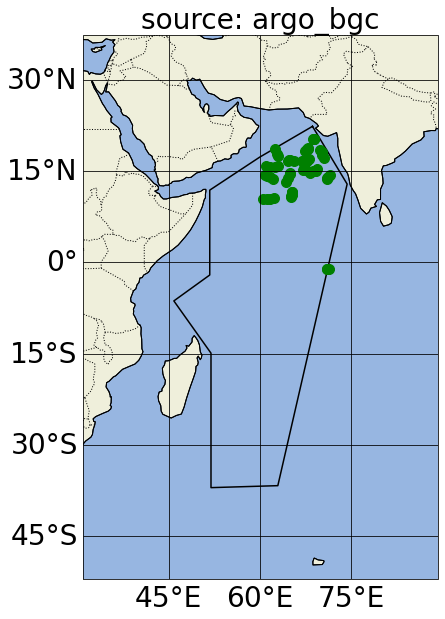

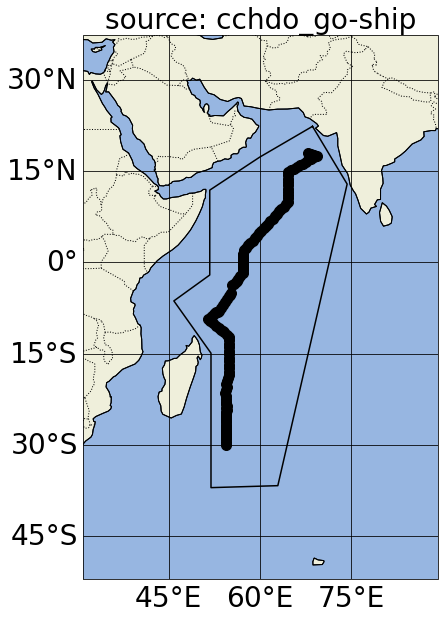

In [5]:
#### EXAMPLES
# select by source and make a plot
source_all = ['argo_core','argo_bgc','cchdo_go-ship']
for isource in source_all:
    bfr_df = get_data_for_timeRange(startDate=startDate,endDate=endDate, \
                                url_prefix=url_prefix+'/profiles?', \
                                myAPIkey=myAPIkey, \
                                    data='temp,metadata-only', \
                                source=isource, \
                                polygon=polygon, \
                                dt_tag='365d',writeFlag=True)
    if not bfr_df.empty:
        bfr_info = get_info_from_df(df=bfr_df,info_to_store=info_to_store)
        ###### let's plot the polygon and the profile locations color coded by source
        set_map_and_plot_locations_withColor(lon=bfr_info['lon'],lat=bfr_info['lat'], \
                                     cols=bfr_info['cols_bySource'], \
                                     polygon_lon_lat_dict=polygon_lon_lat_dict)
        plt.title('source: ' + isource,fontsize=28)

In [6]:
##### search all profiles in polygon for the variable combinations of interest
# NOTE: pres is required anytime data queries are made
datavars_all  =  ['doxy,pres'] #['temp','temperature_btl'] #

for idatavars in datavars_all:
    df = get_data_for_timeRange(startDate=startDate,endDate=endDate, \
                                    url_prefix=url_prefix+'/profiles?', \
                                    myAPIkey=myAPIkey, \
                                    data=idatavars+',metadata-only', \
                                    polygon=polygon, \
                                    dt_tag='100d',writeFlag=True)
    if not df.empty:
        if 'df_all' in locals():
            df_all = pd.concat([df_all,df],ignore_index=True)
        else:
            df_all = df
# store some info
info_d_reg = get_info_from_df(df=df_all,info_to_store=info_to_store)

# delete df_all
del df_all

Number of items: 188
https://argovis-api-atoc-argovis-dev.apps.containers02.colorado.edu/profiles?&startDate=2018-04-27T00:00:00Z&endDate=2018-06-05T23:59:59Z&polygon=[[68.663028,22.389257],[59.970225,17.320499],[51.759644,11.897995],[51.759644,-2.067321],[45.853643,-6.331603],[51.9633,-14.929825],[51.9633,-37.056256],[62.960682,-36.730509],[74.365374,12.892522],[68.663028,22.389257]]&data=doxy,pres,metadata-only


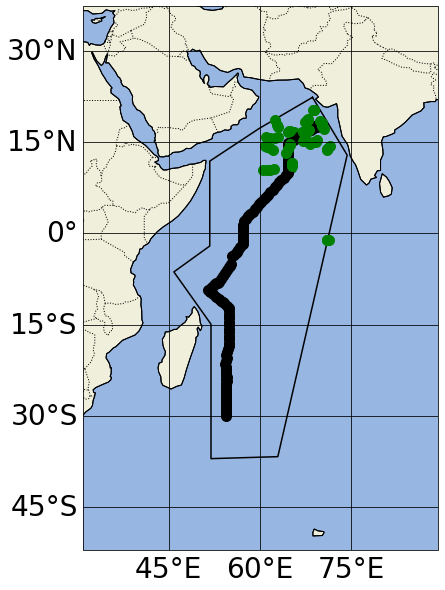

In [7]:
###### let's plot the polygon and profile locations color coded by source
set_map_and_plot_locations_withColor(lon=info_d_reg['lon'],lat=info_d_reg['lat'], \
                                     cols=info_d_reg['cols_bySource'], \
                                     polygon_lon_lat_dict=polygon_lon_lat_dict)

In [8]:
# now search by woceline and then check what Argo profiles are nearby
woceline  = 'I07N'
source    = 'cchdo_go-ship'

if 'df_d1' in locals():
    del df_d1

#datavars_all = ['doxy']

for idatavars in datavars_all:
    df = get_data_for_timeRange(startDate=startDate,endDate=endDate, \
                                    url_prefix=url_prefix+'/profiles?', \
                                    myAPIkey=myAPIkey, \
                                    data=idatavars+',metadata-only', \
                                    woceline=woceline, \
                                    dt_tag='365d',writeFlag=True)
    if not df.empty:
        if 'df_d1' in locals():
            df_d1 = pd.concat([df_d1,df],ignore_index=True)
        else:
            df_d1 = df
# store some info
info_d1 = get_info_from_df(df=df_d1,info_to_store=info_to_store)

Number of items: 124
https://argovis-api-atoc-argovis-dev.apps.containers02.colorado.edu/profiles?&startDate=2018-04-27T00:00:00Z&endDate=2018-06-05T23:59:59Z&data=doxy,pres,metadata-only&woceline=I07N


Text(0.5, 1.0, 'I07N')

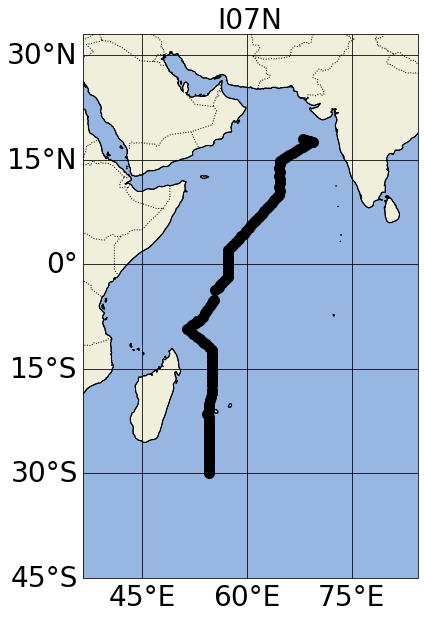

In [9]:
font = {'weight' : 'normal',
        'size'   : 24}

plt.rc('font', **font)
set_map_and_plot_locations_withColor(lon=info_d1['lon'],lat=info_d1['lat'], \
                                     cols=info_d1['cols_bySource'], \
                                     polygon_lon_lat_dict=[])
plt.title(woceline,fontsize=28)

In [10]:
# for a woceline of interest, plot nearby Argo profiles (store the location of the argo profiles to plot a map of locations later)
delta_days = 3.5
argo_source='argo_core'
radius_km='50'

# this needs to be rewritten as function

if 'df_d2' in locals():
    del df_d2

lst_id_pairs_d1 = []
lst_id_pairs_d2 = []

for idatavars in datavars_all:
    for i in np.arange(0,len(info_d1['lon'])):
        time.sleep(.2)
        d = get_data_for_timeRange(startDate=(datetime.strptime(info_d1['date'][i],'%Y-%m-%dT%H:%M:%SZ')- \
                                              timedelta(days=delta_days)).strftime('%Y-%m-%dT%H:%M:%SZ'),
                                   endDate=(datetime.strptime(info_d1['date'][i],'%Y-%m-%dT%H:%M:%SZ')+ \
                                              timedelta(days=delta_days)).strftime('%Y-%m-%dT%H:%M:%SZ'), \
                                   myAPIkey=myAPIkey, \
                                   center=str(info_d1['lon'][i])+','+str(info_d1['lat'][i]), \
                                   radius_km=radius_km, \
                                   url_prefix=url_prefix+'/profiles?', \
                                   data=idatavars+',metadata-only', \
                                   source=argo_source, \
                                   dt_tag='365d',writeFlag=False)
        if not d.empty:
            #info_d2 = {**info_d2, **get_info_from_df(df=d,info_to_store=info_to_store)}
            #list_d2 = list_d2 + [d]
            if 'df_d2' in locals():
                df_d2 = pd.concat([df_d2,d],ignore_index=True)
            else:
                df_d2 = d
            lst_id_pairs_d2.append(d['_id'].tolist())
            lst_id_pairs_d1.append(info_d1['ids'][i])
#
info_d2=get_info_from_df(df=df_d2,info_to_store=info_to_store)
###


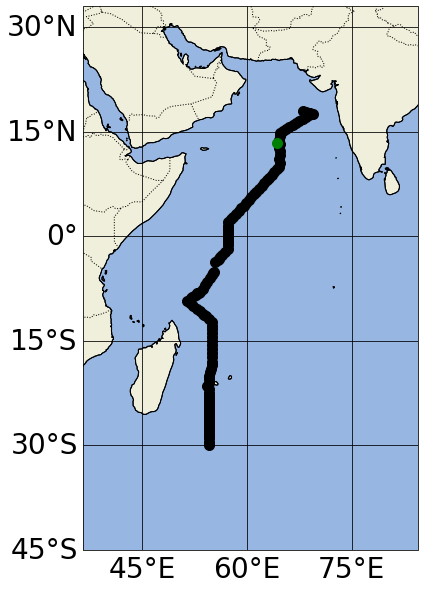

In [11]:
###### let's plot the profile locations color coded by source
set_map_and_plot_locations_withColor(lon=info_d1['lon']+info_d2['lon'],lat=info_d1['lat']+info_d2['lat'], \
                                     cols=info_d1['cols_bySource']+info_d2['cols_bySource'])

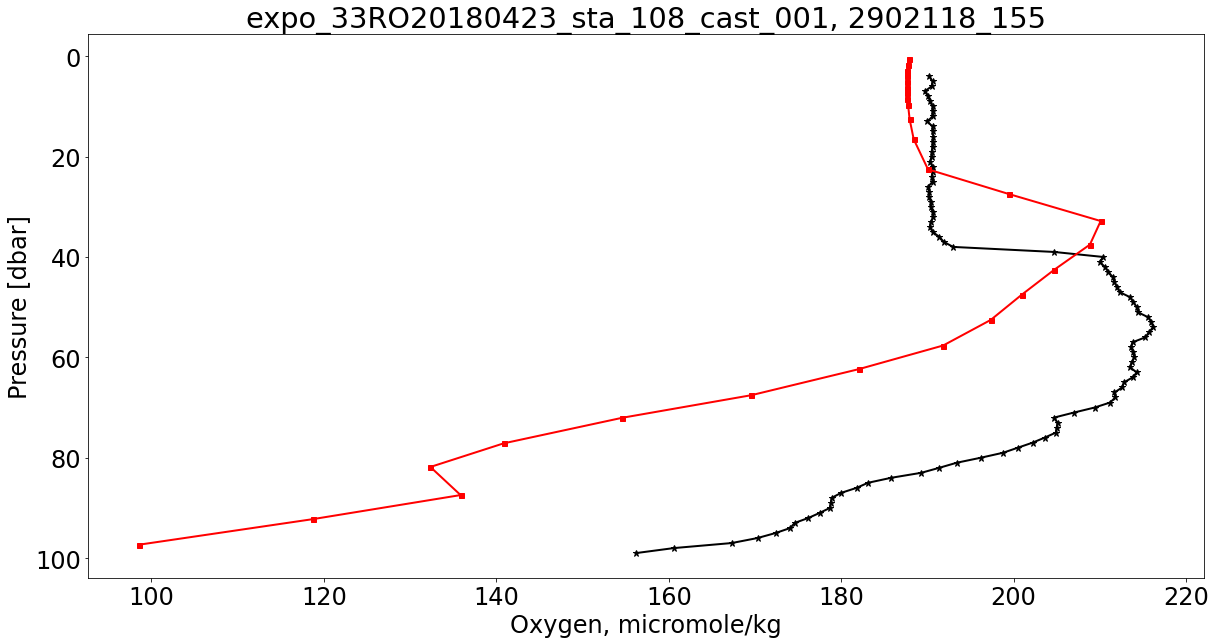

In [12]:
######## compare variable of interest (if available in both sources)
font = {'weight' : 'normal',
        'size'   : 24}

plt.rc('font', **font)

col_d1 = 'k'
col_d2 = 'r'

var_d1 = 'doxy' # NOTE that we compare doxy even if up to this point we made all the plots for temperature
var_d2 = 'doxy'

mrk_sz1 = 7
mrk_sz2 = 5

mrk_type1 = '*'
mrk_type2 = 's'

presRange ='0,100'

# this needs to be rewritten as function
#
for i in np.arange(0,len(lst_id_pairs_d1),1):
    ids_bfr1 = lst_id_pairs_d1[i]
    ids_bfr2 = lst_id_pairs_d2[i]
    if isinstance(ids_bfr1,str):
        ids_bfr1 = [ids_bfr1]
    if isinstance(ids_bfr2,str):
        ids_bfr2 = [ids_bfr2]
        
    fig = plt.figure(figsize=(20,10))
    fig_close = True
    
    if 'bfr_title' in locals():
        del bfr_title
        
    # plot 
    for isource in [1,2]:
        if 'ids_bfr' in locals():
            del ids_bfr
        ids_bfr = eval('ids_bfr'+str(isource))
        # print(ids_bfr)
        for j in ids_bfr:
            bfr = pd.DataFrame(get_data_from_url(url=url_prefix+'/profiles?&data='+var_d2+',pres&id='+j+'&presRange='+presRange,\
                                                 myAPIkey=myAPIkey,writeFlag=False))
            
            if 'bfr_df' in locals():
                del bfr_df

            for j_df in bfr['data']:
                if not 'bfr_df' in locals():
                    bfr_df = pd.DataFrame(j_df)
                else:
                    bfr_df = pd.concat([bfr_df,j_df],ignore_index=True)
            if eval('var_d'+str(isource)) in bfr_df.keys():
                bfr_df2plt = bfr_df[bfr_df.eval(eval('var_d'+str(isource))).notnull()]
                plt.plot(bfr_df2plt[eval('var_d'+str(isource))],bfr_df2plt['pres'], \
                         marker=eval('mrk_type'+str(isource)),markersize=eval('mrk_sz'+str(isource)),color=eval('col_d'+str(isource)),linewidth=2)
                if isource ==2:
                    fig_close = False
                if not 'bfr_title' in locals():
                    bfr_title = j # eval('var_d'+str(isource))
                else:
                    bfr_title = bfr_title + ', ' + j #eval('var_d'+str(isource))
    plt.gca().invert_yaxis()
    plt.title(bfr_title)
    plt.xlabel(set_ax_label(var_d1))
    plt.ylabel(set_ax_label('pres'))
    if fig_close:
        plt.close(fig)

In [13]:
woceline_all = ['160W', '40N', '75N', 'A01', 'A01E', 'A02', 'A05', 'A08', 'A09', 'A09.5', 'A095', 'A10', \
                'A11', 'A12', 'A13', 'A13.5', 'A14', 'A15/AR15', 'A16C', 'A16N', 'A16N/AR21', 'A16S', \
                'A17', 'A20', 'A21', 'A22', 'A23', 'A24', 'A9.5', 'AAIW05', 'ACT2010', 'AJAX', 'ANAS1', \
                'ANAS2', 'ANAS3', 'ANAS4', 'ANAS7', 'AO-01', 'AO94', 'AO95', 'AR01', 'AR02', 'AR03', 'AR04', \
                'AR04EW', 'AR07', 'AR07E', 'AR07E/AR25', 'AR07W', 'AR07W/AR13', 'AR08', 'AR09', 'AR10', 'AR11', \
                'AR12', 'AR13', 'AR15', 'AR16', 'AR18', 'AR19', 'AR21', 'AR24', 'AR25', 'AR28', 'ARK-II_3', \
                'ARK-IV_3', 'ARS01', 'ATAS1', 'AWS02I', 'Albatross', 'CBL', 'CLMD2', 'CLMD5', 'DIMES UK1', \
                'DIMES UK2', 'DIMES UK4', 'DIMES US1', 'DIMES US2', 'Drake Passage', 'HLY0201', 'I01E', \
                'I01W', 'I02', 'I02W', 'I03', 'I04/I05W/I07C', 'I05', 'I05P', 'I07', 'I07N', 'I09N', 'I10', \
                'IR01W', 'IR01W/IR03', 'IR03', 'IR04', 'IR06', 'ISS01', 'ISS02', 'ISS03', 'JOIS97', 'KESS', \
                'LINE-W', 'NACPWCC', 'ODEN91', 'OISO', 'OISO19', 'P01', 'P01C', 'P01E', 'P01H', 'P01W', 'P02', \
                'P02C', 'P02E', 'P02T', 'P02W/PR27', 'P03', 'P03W', 'P04C', 'P04E', 'P04W', 'P05', 'P06C', 'P06E', \
                'P06W', 'P08N', 'P08S', 'P09', 'P10', 'P11A', 'P11S', 'P12', 'P13', 'P13J', 'P14', 'P14C', 'P14N', \
                'P14S', 'P14S,P15S', 'P15N', 'P15N/PR06', 'P15S', 'P16', 'P16A/P17A', 'P16C', 'P16N', 'P16S', \
                'P16S/P17S', 'P17C', 'P17N', 'P19A', 'P19C', 'P21', 'P21E', 'P21W', 'P24', 'P31', 'P414', 'PR01', \
                'PR01S', 'PR02', 'PR03', 'PR03/PCM06', 'PR04', 'PR05/PR06', 'PR06', 'PR06/PRS01', 'PR11', \
                'PR11/PR13N', 'PR11/PR31', 'PR12', 'PR13N', 'PR14', 'PR15', 'PR16', 'PR17', 'PR18', 'PR19', \
                'PR20', 'PR21', 'PR23', 'PR23,PR24', 'PR23/PR24', 'PR24', 'PR27', 'PR32', 'PRS02', 'S04', \
                'S04I', 'S04P', 'S05', 'SAVE1', 'SAVE2', 'SAVE3', 'SAVE4', 'SBI', 'SR01', 'SR01B', 'SR02', \
                'SR02/SR04', 'SR03', 'SR04', 'SR1B', 'SR3S4', 'XP99']


404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not found: No matching results found in database.
404: Not f

Number of items: 293
https://argovis-api-atoc-argovis-dev.apps.containers02.colorado.edu/profiles?&startDate=2014-12-04T00:00:00Z&endDate=2015-12-04T00:00:00Z&source=cchdo_go-ship
Number of items: 403
https://argovis-api-atoc-argovis-dev.apps.containers02.colorado.edu/profiles?&startDate=2015-12-04T00:00:00Z&endDate=2016-12-03T00:00:00Z&source=cchdo_go-ship
Number of items: 58
https://argovis-api-atoc-argovis-dev.apps.containers02.colorado.edu/profiles?&startDate=2016-12-03T00:00:00Z&endDate=2017-12-03T00:00:00Z&source=cchdo_go-ship
Number of items: 195
https://argovis-api-atoc-argovis-dev.apps.containers02.colorado.edu/profiles?&startDate=2017-12-03T00:00:00Z&endDate=2018-12-03T00:00:00Z&source=cchdo_go-ship
Number of items: 70
https://argovis-api-atoc-argovis-dev.apps.containers02.colorado.edu/profiles?&startDate=2018-12-03T00:00:00Z&endDate=2019-12-03T00:00:00Z&source=cchdo_go-ship
Number of items: 134
https://argovis-api-atoc-argovis-dev.apps.containers02.colorado.edu/profiles?&sta

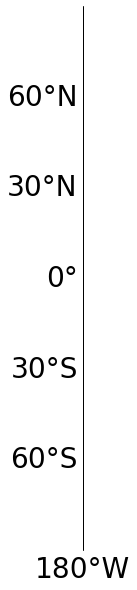

In [14]:
# this needs to be rewritten as function
#
# now search by woceline and then check what Argo profiles are nearby (did not do this yet; it could be added to what is below... 
# once all the go-ship profiles are found, they could be grouped by woceline... for each group distinct instnaces could be identified...
# for each instance (i.e. for each time the woceline was measured), we could do the co-location with Argo profiles (taking parts of code 
# from earlier to build the function)
#woceline_all  = ['I07N', 'A10']
woceline_all  = [''] # if '', woceline is not used in the url (instead of e.g. using the list above)
source        = 'cchdo_go-ship'

startDate = '1900-01-01T00:00:00Z'
endDate   = '2022-03-01T00:00:00Z'

datavars_all = [''] # if '', datavar is not used in the url

fig = plt.figure(figsize=(20,10))
set_up_map(set_extent_info=[-180, 180, -90, 90],central_long=180,delta_lonGrid=30,delta_latGrid=30,fnt_size=28)

for iwoceline in woceline_all:
    time.sleep(2)
    if 'df_line' in locals():
        del df_line
        del info_df_line
    for idatavars in datavars_all:
        df = get_data_for_timeRange(startDate=startDate,endDate=endDate, \
                                        url_prefix=url_prefix+'/profiles?', \
                                        myAPIkey=myAPIkey, \
                                        data=idatavars, \
                                        source=source, \
                                        woceline=iwoceline, \
                                        dt_tag='365d',writeFlag=True)
        if not df.empty:
            if 'df_line' in locals():
                df_line = pd.concat([df_line,df],ignore_index=True)
            else:
                df_line = df
    if 'df_line' in locals():
        # store some info
        info_df_line = get_info_from_df(df=df_line,info_to_store=info_to_store)

        plot_locations_withColor(lon=info_df_line['lon'],lat=info_df_line['lat'], \
                                         cols=info_df_line['cols_bySource'],markersz=5)

In [15]:
info_df_line = get_info_from_df(df=df_line,info_to_store=info_to_store)

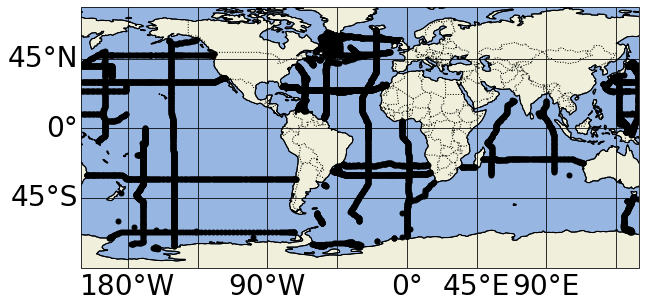

In [16]:
set_map_and_plot_locations_withColor(lon=info_df_line['lon'],lat=info_df_line['lat'], \
                                     cols=info_df_line['cols_bySource'],markersz=5,delta_lonGrid=45,delta_latGrid=45)

In [17]:
#### for each of the points along a woce line, plot nearby Argo profiles

In [18]:
# dictOne = {"Column A":[1, 2],"Column B":[4, 5, 6],"Column C":[7]}
# dictTwo = {"Column A":[1, 2],"Column B":[4, 5, 6],"Column D":[4, 5, 6,4, 5, 6]}
# lst = [dictOne,dictTwo]
# pd.DataFrame(lst)

In [19]:
# df_ALL = get_data_for_timeRange(startDate=startDate,endDate=endDate, \
#                                     url_prefix=url_prefix+'/profiles?', \
#                                     data=data, \
#                                     polygon=polygon,presRange='', \
#                                     dt_tag='10d',writeFlag=True)
    
# info_select_dict = get_info_from_df(df=df_ALL,info_to_store=info_to_store)
# plot_locations_withColor(lon=info_select_dict['lon'],lat=info_select_dict['lat'], \
#                          cols=info_select_dict['cols_bySource'],dx=30,dy=30,central_long=-30, \
#                          markersz=10,fnt_size=28)